#Destination prediction by best match

This page contains the code to predict the trajectory destinations based on the best match to the historical taxi trajectory data. As such, it is does not rely on any statistical machine learning, however does closely resembly K-nearest neighbor in that it is an example of instance-based learning. The algorithm implemented below includes several preprocessing steps before the prediction, such as median-filtering of the trajectories as well as lowering of their resolutions by merging points under a given precision (e.g. points within 30 meters are merged into a single point).

In [45]:
from __future__ import division
import numpy as np
import pandas as pd
import re
from mpl_toolkits.basemap import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [27]:
def qc(cell):
    "Find cells containing polylines based on expected format"
    match = re.search(r'^\[\[[-\d,\.\[\]]+\]\]$', cell)
    if match:
        return np.asarray(eval(cell))
    else:
        return np.nan

In [28]:
def median_filter(traj, lag=4):
    "Compute the running median with the given lag"
    x = traj[:, 0]
    y = traj[:, 1]
    filt_x = np.zeros_like(x)
    filt_y = np.zeros_like(y)
    try:
        for ax, filt_ax in zip([x, y], [filt_x, filt_y]):
            for idx, p in enumerate(ax):
                if idx < lag:
                    filt_ax[idx] = p
                else:
                    win = ax[idx-lag:idx+1]
                    med = np.median(win, overwrite_input=True)
                    filt_ax[idx] = med
    except IndexError:
        print p
        print ax
        print idx
        print

    traj_filt = np.c_[filt_x, filt_y]
    return traj_filt

In [34]:
def to_lores(cell, proj, precision=30):
    '''Convert latitude/longitude coordinates to lower 
    resolution cartesian coordinates to within `precision' meters'''
    origin = cell[0]
    x, y = proj(*origin)
    x = int(round(x/precision)*precision)
    y = int(round(y/precision)*precision)
    lores = np.array([[x, y]])
    try:
        for coord in cell[1:]:
            x, y = proj(*coord)
            x = int(round(x/precision)*precision)
            y = int(round(y/precision)*precision)
            if (lores[-1] == (x, y)).all():
                continue
            else:
                lores = np.vstack((lores, (x, y)))
    except IndexError:
        return lores
    return lores

In [38]:
def kaggle_haversine(coord1, coord2, r = 6371.0):
    "Calculate the haversine distance using lat/lon coordinates"
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat = abs(lat1-lat2)*np.pi/180
    lon = abs(lon1-lon2)*np.pi/180
    lat1 = lat1*np.pi/180
    lat2 = lat2*np.pi/180
    a = np.sin(lat/2)*np.sin(lat/2)+np.cos(lat1)*np.cos(lat2)*np.sin(lon/2)*np.sin(lon/2)
    d = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = r*d
    return(d)

In [238]:
def ctrMass(traj):
    "Find the center-of-mass vector of a trajectory in cartesian coordinates"
    if len(traj) == 1:
        print traj
        raise ValueError("Only a single coordiate provided")
    try:
        xs = traj[:, 0]
        ys = traj[:, 1]
        xsq = xs**2
        ysq = ys**2
        xnum = np.sum(xsq[1:]-xsq[:-1], axis=None)
        ynum = np.sum(ysq[1:]-ysq[:-1], axis=None)
        xden = 2*np.sum(xs[1:]-xs[:-1], axis=None)
        yden = 2*np.sum(ys[1:]-ys[:-1], axis=None)
        ctr = np.array([xnum/xden, ynum/yden])
    except:
        print traj
        print 'space'
        raise ValueError
    return ctr


def ctrDist(traj1, traj2):
    "Euclidian distance of the centers of mass for two trajectories"
    ctr1 = ctrMass(traj1)
    ctr2 = ctrMass(traj2)
    dist = np.sqrt(np.sum((ctr1 - ctr2)**2, axis=None))
    return dist


def dispVec(traj):
    "Calculate the end-to-end displacement vector for a trajectory"
    dispvec = traj[-1]-traj[0]
    return dispvec


def cosSim(dispvec1, dispvec2):
    "Calculate the cosine similarity of two displacement vectors"
    dot = np.dot(dispvec1, dispvec2)
    norm1, norm2 = np.linalg.norm(dispvec1), np.linalg.norm(dispvec2)
    ret = dot/(norm1*norm2)
    return ret


def get_len(traj, latlon = False):
    "Calculate the total length of trajectory using each segment"
    assert type(traj) == np.ndarray, "Trajectory not of type ndarray: of {}".format(type(traj))
    assert traj.ndim == 2, "Trajectory does not have 2 dimensions: shape is {}".format(traj.shape)
    assert len(traj) > 1, "Trajectory is a single point"
    dists = 0.
    if latlon:
        for idx, coord2 in enumerate(traj[1:]):
            coord1 = traj[idx]
            dist = kaggle_haversine(coord1, coord2)
            dists += dist
        return dists
    else:
        for idx, coord2 in enumerate(traj[1:]):
            coord1 = traj[idx]
            dist = np.sqrt(((coord2-coord1)**2).sum())
            dists += dist
        return dists

In [40]:
def geoDist(traj1, traj2):
    '''Calculate the geometric distance of two trajectories in 
    cartesian coordinates (see http://www.cise.ufl.edu/~mschneid/Research/papers/LS12IWGS.pdf)'''
    ctr_dist = ctrDist(traj1, traj2)
    norm1, norm2 = np.linalg.norm(traj1), np.linalg.norm(traj2)
    len1, len2 = get_len(traj1), get_len(traj2)
    diff_length = abs(len1 - len2)/max(len1, len2)
    dispvec1, dispvec2 = dispVec(traj1), dispVec(traj2)
    dispvec1_norm, dispvec2_norm = np.linalg.norm(dispvec1), np.linalg.norm(dispvec2)
    avg_disp = np.mean((dispvec1_norm, dispvec2_norm))
    csim = cosSim(dispvec1, dispvec2)
    res = abs(ctr_dist*(diff_length + 1)-avg_disp*(csim))
    return res

<img src="geodist.jpg">

In [29]:
# Using mpl_toolkits.basemap's python-based Proj4 wrapper I instantiate a transverse mercator projection
# with (0,0) at lat_0, lon_0. The string is interpreted into a transform function that can accept latlon
# coordinates and produce cartesian coordinates on the map

sproj = '+proj=tmerc +lat_0=41.06 +lon_0=-8.765127 +x_0=0 +y_0=0 +k_0=1 +lat_ts=41 +ellps=GRS80 +units=m +no_defs'
proj = pyproj.Proj(sproj)

In [271]:
train_data_path = ('/Users/Bronco/Classes/General_assembly/'  +
                   'DAT_SF_13_homework/Final_project/kaggle/' +
                   'taxi_trajectory_prediction/train.csv')

In [272]:
train_data = pd.read_csv(train_data_path, chunksize=500) # Specifying chunksize returns a TextFileReader, not DataFrame
chunk = train_data.read(10000) # Read 5000 rows into the TextFileReader and put into DataFrame

In [273]:
# Extract POLYLINE, make sure all polylines are in the correct format, drop rows missing polylines, turn into
# ndarrays, perform median filtering, and convert to lower resolution using `proj'

plines = chunk.POLYLINE.apply(qc).dropna().apply(np.asarray).apply(median_filter).apply(to_lores, args=(proj,))

In [274]:
# Save a hires version that has been filtered

hires_plines = chunk.POLYLINE.apply(qc).dropna().apply(np.asarray).apply(median_filter)

In [275]:
# Get lengths of the polylines for hires and lores versions

lens = np.asarray([len(x) for x in plines])
hilens = np.asarray([len(x) for x in hires_plines])

1 1
670 922
33.0 41.0
37.1997991968 48.6187751004


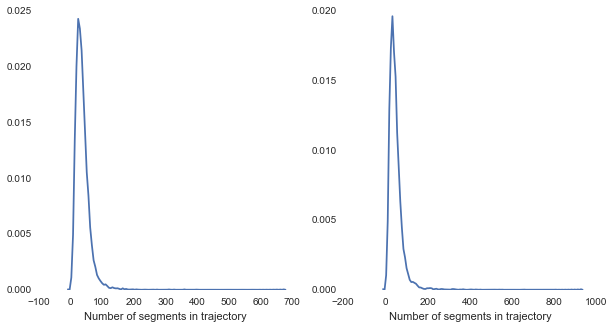

In [276]:
# Plot length distributions to show that many points do get merged when converting to lores

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
sns.kdeplot(lens, ax=ax1)
sns.kdeplot(hilens, ax=ax2)
ax1.set_xlabel("Number of segments in trajectory")
ax2.set_xlabel("Number of segments in trajectory")
print min(lens), min(hilens)
print max(lens), max(hilens)
print np.median(lens), np.median(hilens)
print np.mean(lens), np.mean(hilens)

In [251]:
def get_random_traj(pool, samples=10, min_len = 25): # Not used in the analysis
    "Function to select random trajectories meeting min_length criteria."
    assert type(pool) == pd.Series, "Wrong input type. Is {}".format(type(pool))
    n = len(pool)
    choices = np.random.choice(n, samples+50, replace=False) #pick extra in case some are inadequate
    random_trajs = []
    chosen = []
    for c in choices:
        if len(random_trajs) == samples:
            break
        cand = pool[c]
        if len(cand) >= min_len:
            random_trajs.append(cand)
            chosen.append(c)
    pool.index = range(len(pool))
    pool.drop(chosen, inplace=True)
    return pd.Series(random_trajs), pool


def prog_trunc(traj, n_truncs=4):
    "Make progressive truncations of selected trajectory, with `n_truncs + 1` final truncations"
    assert type(traj) == np.ndarray, "Trajectory not ndarray. Of {}".format(type(traj))
    trunc_length = len(traj)//(n_truncs + 1)
    trunc_list = [traj]
    for trunc in range(n_truncs,0,-1):
        tr = traj[:trunc_length*trunc]
        if len(tr) == 1:
            tr = np.vstack(tr)
        trunc_list.append(tr)
    return trunc_list


def match_trunc(trunc, traj, matches, n_matches=5, min_length_match=10, save_worst=False):
    "Update trunc matches with respect to traj"
    if len(traj) >= min_length_match:
        gd = geoDist(trunc, traj)
        if save_worst:
            for rank in range(-1, -n_matches-1, -1):
                if gd > matches[rank]['gd']:
                    matches[rank]['gd']=gd
                    matches[rank]['match']=traj
                    break
        for rank in range(1,n_matches+1):
            if gd < matches[rank]['gd']:
                matches[rank]['gd']=gd
                matches[rank]['match']=traj
                break
    return

In [266]:
from sklearn.cross_validation import train_test_split
import copy

def KNN_geodist(train_set, test_set, n_matches=5, min_length_match=10, save_worst=False, perform_trunc=True, n_truncs=4):
    "Peform matching based on geoDist function from entire test set and pool"
    if perform_trunc:
        trunc_list_list = []
        match_results = {i:[] for i in range(n_truncs+1)}
        matches = {i:{'gd':1e6, 'match':None} for i in range(1, n_matches+1)}
        if save_worst:
            matches.update({i:{'gd':0, 'match':None} for i in range(-1, -n_matches-1, -1)})
        for traj in test_set:
            trunc_list = prog_trunc(traj, n_truncs=n_truncs)
            trunc_list_list.append(trunc_list)
            for i in match_results:
                match_results[i].append(copy.deepcopy(matches))
        for train in train_set:
            for idx2, trunc_list in enumerate(trunc_list_list):
                for idx1, trunc in enumerate(trunc_list):
                    if len(trunc) >= 2:
                        matches = match_results[idx1][idx2]
                        match_trunc(trunc, 
                                    train,
                                    matches,
                                    n_matches=n_matches, 
                                    min_length_match=min_length_match, 
                                    save_worst=save_worst)
    '''else:
        match_results = []
        for traj in test_set:
            matches = match_trunc(traj,
                                  train_set, 
                                  n_matches=n_matches, 
                                  min_length_match=min_length_match, 
                                  save_worst=save_worst)
            matches_results.append(matches)'''
    return match_results
            

In [277]:
train, test = train_test_split(plines, test_size=.1)
train_to_drop = map(lambda x: False if len(x)<2 else True, train)
test_to_drop = map(lambda x: False if len(x)<2 else True, test)
train = train[np.where(train_to_drop)]
test = test[np.where(test_to_drop)]

In [278]:
%%time
match_results = KNN_geodist(train, test)

CPU times: user 12h 10s, sys: 1min 52s, total: 12h 2min 2s
Wall time: 12h 1min 13s


In [92]:
import cPickle as cp

with open('match_results_5000.pkl', 'wb') as mr:
    cp.dump(match_results, mr, protocol=-1)

In [303]:
from itertools import izip 

def get_best_match(true_dest, matches, proj):
    xy = matches[1]['match'][-1]
    ll = proj(*xy, inverse=True)
    ll_true = proj(*true_dest, inverse=True)
    hav = kaggle_haversine(ll_true[::-1], ll[::-1])
    return hav


def get_mean_best(true_dest, matches, proj, use_weights=False):
    all_xy = np.asarray([matches[i]['match'][-1] for i in range(1,max(matches.iterkeys())+1)])
    if use_weights:
        all_weights = np.asarray([matches[i]['gd']**-2 for i in range(1,max(matches.iterkeys())+1)])
        all_weights = all_weights/np.sum(all_weights)
        all_xy = np.asarray([all_xy[i]*all_weights[i] for i in range(len(all_xy))])
        mean_xy = all_xy.sum(0)
    else:
        mean_xy = all_xy.mean(0)
    mean_ll = proj(*mean_xy, inverse=True)
    ll_true = proj(*true_dest, inverse=True)
    hav = kaggle_haversine(ll_true[::-1], mean_ll[::-1])
    return hav

def assess_results(test_set, match_results, proj):
    hack_dict = {1: {'gd': 1000000.0, 'match': None}, 
                 2: {'gd': 1000000.0, 'match': None}, 
                 3: {'gd': 1000000.0, 'match': None}, 
                 4: {'gd': 1000000.0, 'match': None}, 
                 5: {'gd': 1000000.0, 'match': None}}
    '''if type(match_results) is list:
        scores = []
        for t, r in izip(test, match_results):
            gds = np.asarray([v['gd'] for v in r.itervalues()])
            match_dests = np.asarray([v['match'][-1] for v in r.itervalues()])
            gds = gds**-2
            score = np.dot(match_dests.T'''
    hav_scores = {i:{'best':[], 'mean':[], 'weighted_mean':[]} for i in match_results}
    for idx, test_traj in enumerate(test_set):
        true_dest = test_traj[-1]
        for k in match_results:
            if (match_results[k][idx] is None) or (match_results[k][idx] == hack_dict):
                ll = proj(*true_dest, inverse=True)
                hav = kaggle_haversine(ll[::-1], [41.1621429,-8.6218531])
                for t in hav_scores[k].iterkeys():
                    hav_scores[k][t].append(hav)
                continue
            hav_b = get_best_match(true_dest, match_results[k][idx], proj)
            hav_scores[k]['best'].append(hav_b)
            
            hav_m = get_mean_best(true_dest, match_results[k][idx], proj)
            hav_scores[k]['mean'].append(hav_m)
            
            hav_wm = get_mean_best(true_dest, match_results[k][idx], proj, use_weights=True)
            hav_scores[k]['weighted_mean'].append(hav_wm)
    return hav_scores  

In [304]:
hav_scores = assess_results(test, match_results, proj)

In [ ]:
proj()

In [305]:
for k,v in hav_scores.iteritems():
    print '{}-trunc:'.format(k)
    print 'Avg best score: {:.4f}'.format(np.mean(v['best']))
    print 'Avg mean score: {:.4f}'.format(np.mean(v['mean']))
    print 'Avg weighted mean score: {:.4f}'.format(np.mean(v['weighted_mean']))
    print

0-trunc:
Avg best score: 2.8946
Avg mean score: 2.1229
Avg weighted mean score: 2.6262

1-trunc:
Avg best score: 2.8220
Avg mean score: 2.1028
Avg weighted mean score: 2.5745

2-trunc:
Avg best score: 2.7856
Avg mean score: 2.2025
Avg weighted mean score: 2.5940

3-trunc:
Avg best score: 3.0765
Avg mean score: 2.6711
Avg weighted mean score: 2.9195

4-trunc:
Avg best score: 3.5258
Avg mean score: 3.2826
Avg weighted mean score: 12.0225



In [281]:
def plot_scores(score_dict, kwds):
    fig, ax = plt.subplots(1,3, squeeze=True, figsize=(16,5), sharey=True, sharex=True)
    ax1, ax2, ax3 = ax
    fig.suptitle('Log10 of distance in Km from true destination', size=18, horizontalalignment='center', verticalalignment='baseline')
    for k,v in score_dict.iteritems():
        '''sns.kdeplot(np.asarray(v['best']), ax = ax[0], label = '{}-trunc'.format(k), **kwds)
        sns.kdeplot(np.asarray(v['mean']), ax = ax[1], label = '{}-trunc'.format(k), **kwds)
        sns.kdeplot(np.asarray(v['weighted_mean']), ax = ax[2], label = '{}-trunc'.format(k), **kwds)'''
        
        ax1.hist(np.log10(v['best']), bins=50, label = '{}-trunc'.format(k), **kwds)
        ax1.set_title('Best overall match')
        ax2.hist(np.log10(v['mean']), bins=50, label = '{}-trunc'.format(k), **kwds)
        ax2.set_title('Mean of matches')
        ax3.hist(np.log10(v['weighted_mean']), bins=50, label = '{}-trunc'.format(k), **kwds)
        ax3.set_title('Weighted mean of matches')
    for a in ax:
        a.legend()

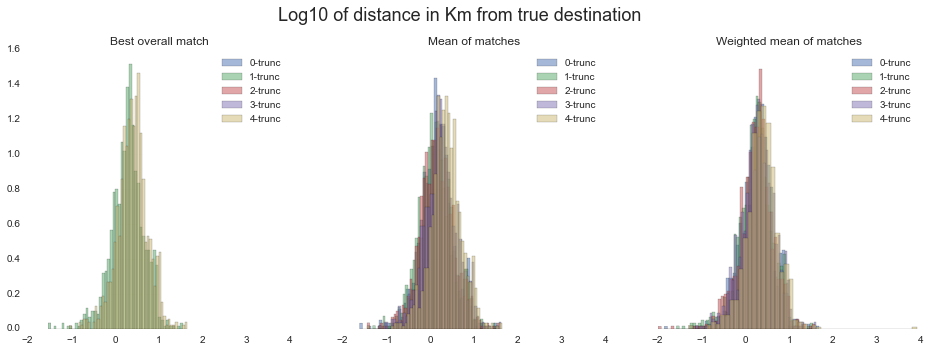

In [306]:
kwds={'histtype':'bar', 'stacked':False, 'alpha':.5, 'normed':True}
plot_scores(hav_scores, kwds)

In [382]:
from mpl_toolkits.basemap import Basemap


def plot_true_vs_pred(test_set, hav_scores):
    llcrnrlat, llcrnrlon = 41.06, -8.765127
    urcrnrlat, urcrnrlon = 41.26, -8.5
    cmap = plt.cm.hsv
    x_true, y_true = np.vsplit(np.asarray([i[-1] for i in test]).T, 2)
    x_true, y_true = np.squeeze(x_true), np.squeeze(y_true)
    shape_dict = {score_type:shape for score_type, shape in zip(hav_scores[0].keys(), ['o', '^', 's'])}
    fig, ax = plt.subplots(1, len(hav_scores), figsize=(50,50), squeeze=True)
    for k,v in hav_scores.iteritems():
        a = ax[k]
        a.set_title('{}-length truncations'.format(k))
        m = Basemap(llcrnrlat = llcrnrlat,
                    llcrnrlon = llcrnrlon,
                    urcrnrlat = urcrnrlat,
                    urcrnrlon = urcrnrlon,
                    projection = 'tmerc',
                    resolution = 'h',
                    lat_0 = llcrnrlat,
                    lon_0 = llcrnrlon,
                    lat_ts = 41.,
                    ax = a)
        m.fillcontinents(lake_color='aqua')
        m.drawmapboundary(fill_color='aqua')
        m.drawrivers(color='aqua', linewidth=3)
        m.drawcoastlines()
        
        for score_type, scores in v.iteritems():
            shape = shape_dict[score_type]
            scatter = m.scatter(x_true, y_true, 
                                marker=shape, 
                                c=scores, 
                                cmap=cmap, 
                                s=60, 
                                alpha=0.2, 
                                label=score_type, 
                                zorder=9)

        m.colorbar(scatter, location='bottom', label='Distance (Km) from true destination')
        m.drawmapscale(llcrnrlon+.07, llcrnrlat+.015, llcrnrlon, llcrnrlat, 10, barstyle='fancy', fontsize=18, zorder=10)
        a.legend()

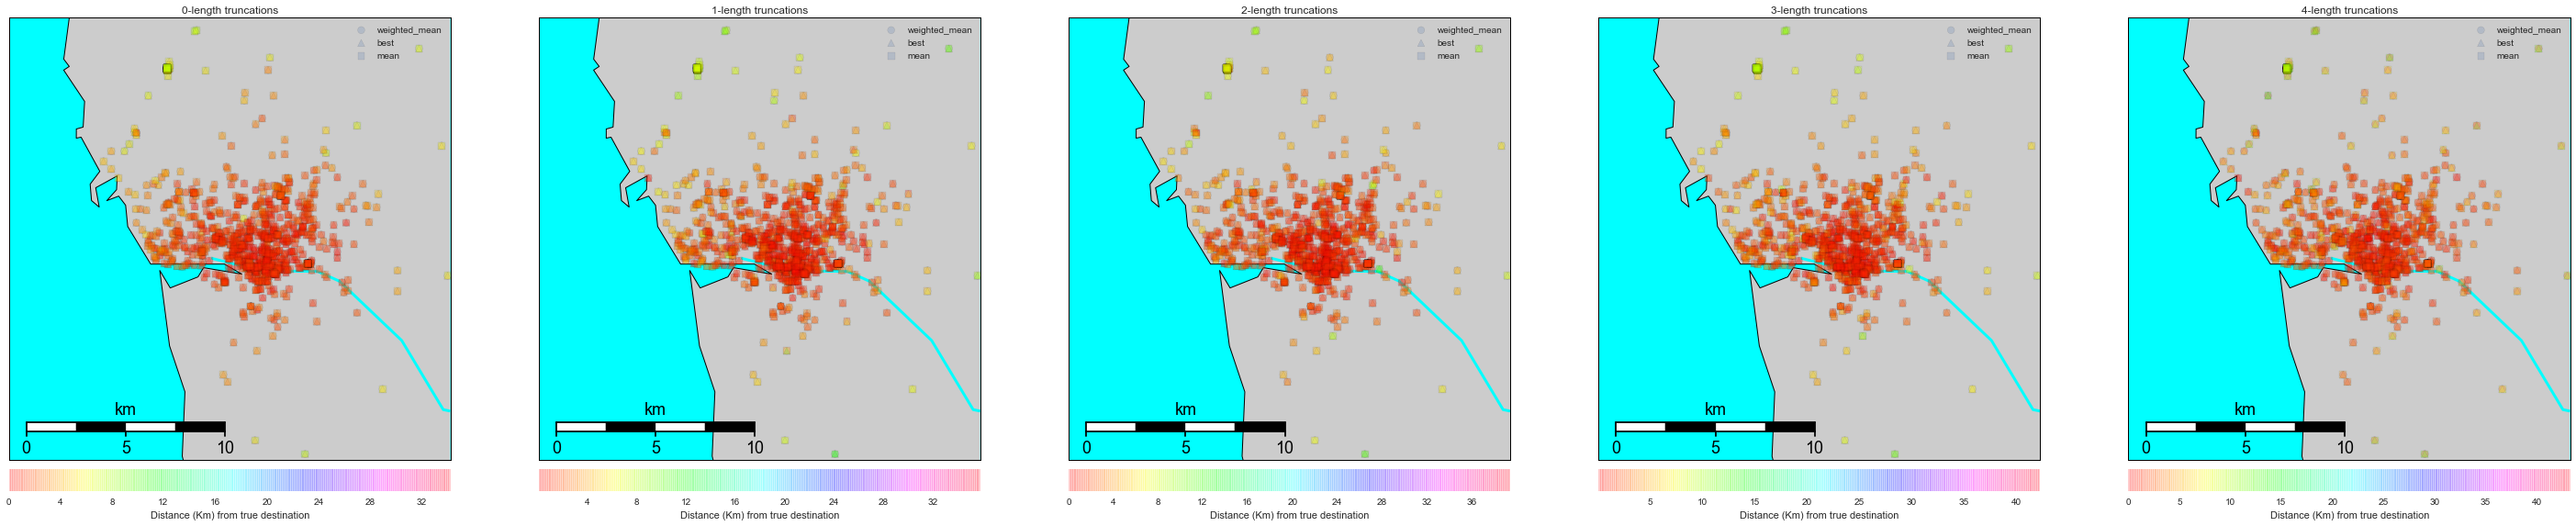

In [383]:
m = plot_true_vs_pred(test, hav_scores)

##Next steps

* Create a version of the dataset that balances training samples with respect to their destinations. Currently the vast majority of the samples are focused around downtown, which increases the liklihood a sample will be predicted to have a destination downtown. Do this by making the local density close to uniform across the map
* Try other methods of prediction besides simple comparison and random forest (e.g. neural network)